In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import (
    GetScan,
    recursive_scan,
    Para_init,
    Run_model_wwo_dry_out ,
    Cal_new_con_Update,
    Run_Model_Base_On_Last_Solution,
    Run_Model_Base_On_Last_Solution_RPT,
    write_excel_xlsx,
    Get_initial_cap,
    Get_initial_cap2,
    handle_signal,
    Run_P2_till_Fail,
)

In [3]:
DryOut = "On"; count_i=2
print(f"Scan {count_i}: DryOut = {DryOut}")
my_dict_RPT= {};my_dict_RPT["Cycle_RPT"]=[0,1,2]

print(my_dict_RPT)

Scan 2: DryOut = On
{'Cycle_RPT': [0, 1, 2]}


In [4]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[1170,],
   "Ageing cycles between RPT":[78,],
   "Update cycles for ageing":[13,],
   "Cycles within RPT":[2,],
   "Ageing temperature":[25,],
   "RPT temperature":[25,],
   "Particle mesh points":[30,],   # Simon uses 30
   #"Exponential mesh stretch":[1.0],
   "Para_Set":[ "Li2023_Coupled",],
   "Model option":[
         {
            "calculate discharge energy":"true",
            "particle": "Fickian diffusion",          
            "SEI":"interstitial-diffusion limited",   
            "SEI on cracks":"true",  
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",      
            "particle mechanics":("swelling and cracking", "swelling only"), 
            "loss of active material":"stress-driven", 
            "lithium plating":"partially reversible"      },
         ],
   "Inner SEI reaction proportion":[0.5,],
   "Ratio of lithium moles to SEI moles":[2,], # I have always been using 1 for solvent consumption model
   "Initial inner SEI thickness [m]":[2.5E-9,],
   "Initial outer SEI thickness [m]":[2.5E-9,],
   "SEI growth activation energy [J.mol-1]":[38000,],
   # Solvent consumption sub-model
   "Initial electrolyte excessive amount ratio":[2,], # set to <1 for DryOut=Off 
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],

   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[1e-24,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity [m2.s-1]':[1e-22,],
   'SEI kinetic rate constant [m.s-1]':[1e-12,], 
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-7,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[3E-10,], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 2.7778e-9,], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 2.7778e-9,], # default: 2.7778e-07
   # make it simple for now,], but may want to have T dependency in the future
   "Negative electrode cracking rate":[ 3.9e-22,],   # default: function, ~3.9e-20
   "Positive electrode cracking rate":[ 3.9e-22,],   # default: function, ~3.9e-20
   "Negative electrode volume change":[ 0.0,],
   "Positive electrode volume change":[ 0.0,],
   "Initial Neg SOC":[0.850],    #list(np.linspace(0.84,0.90,6)),
   "Initial Pos SOC":[0.2705], # list(np.linspace(0.22,0.27,6)),

}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 1


In [5]:
# define experiments and output keys
V_max = 4.2;        
V_min = 2.5; 
exp_AGE_text = [(f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ]
# step index for ageing
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

exp_RPT_text = [ (f"Discharge at 0.1C until {V_min} V",  
        "Rest for 1 hours",  
        f"Charge at 0.1C until {V_max} V" ) ]
# step index for RPT
step_RPT_CD = 0;  step_RPT_RE =1;   step_RPT_CC = 2;  

exp_text_list = [exp_AGE_text, exp_RPT_text,];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_RPT_CD,step_RPT_RE , step_RPT_CC ];

#len(Para_dict_list)

########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    "CDend X-averaged total SEI on cracks thickness [m]",
    "CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    "CDend Throughput capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [6]:

# Main code to run the model
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2R7'; 
#BasicPath=os.getcwd()
Target  = '/d0_int_office/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'd0_int_office.xlsx';

sheet_name_xlsx = 'Results';

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];

# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.insert(1,"Dry out");
head_list.extend([ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"])
write_excel_xlsx(BasicPath + Target+book_name_xlsx, sheet_name_xlsx, [head_list])

Niall_data = loadmat( str_path_1+'\Extracted_all_cell.mat')


Successfully create a excel file


Start Now! Scan 1.
Scan 1: DryOut = On
Initial electrolyte amount is  10.735436400000001 mL
Scan 1: Finish break-in cycle
Electrolyte is being squeezed out, check plated lithium (reversible part)
Temperature for ageing is now: 298.15
Electrolyte is being squeezed out, check plated lithium (reversible part)
Temperature for ageing is now: 298.15
Temperature for ageing is now: 298.15
Temperature for ageing is now: 298.15
Temperature for ageing is now: 298.15
Temperature for ageing is now: 298.15
Temperature for RPT is now: 298.15
Temperature for ageing is now: 298.15
Electrolyte is being squeezed out, check plated lithium (reversible part)
Temperature for ageing is now: 298.15
Temperature for ageing is now: 298.15
Temperature for ageing is now: 298.15
Temperature for ageing is now: 298.15
Temperature for ageing is now: 298.15
Temperature for RPT is now: 298.15
Temperature for ageing is now: 298.15
Electrolyte is being squeezed out, check plated lithium (reversible part)
Temperature for ag

' \nif __name__ == "__main__":\n    pool = multiprocessing.Pool(1)\n    processes = [pool.apply_async(\n        Run_model_wwo_dry_out, \n        args=(\n            index_list_i, Para_dict_i,   Path_pack,\n            keys_all,   exp_text_list, exp_index_pack,Niall_data\n        )\n            ) \n            for index_list_i, Para_dict_i in zip(index_list,Para_dict_list)]\n    result = [p.get() for p in processes]\n '

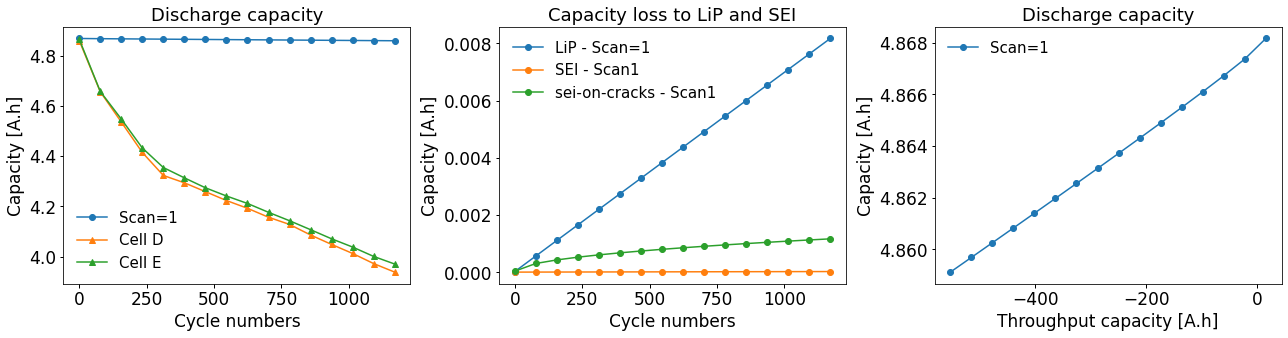

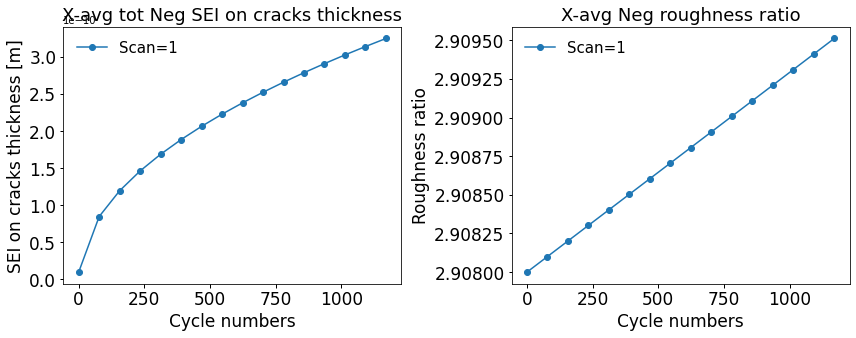

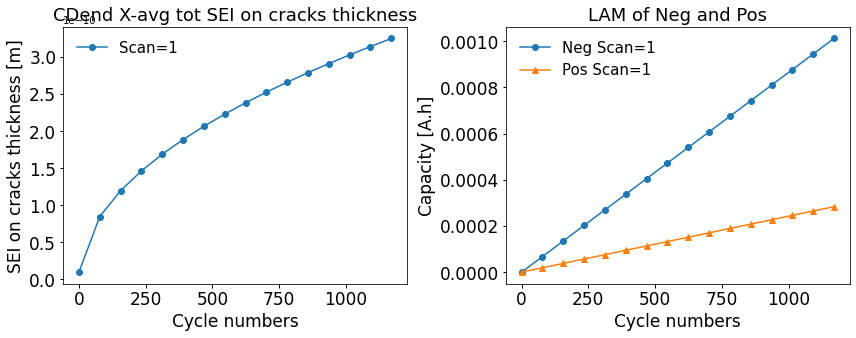

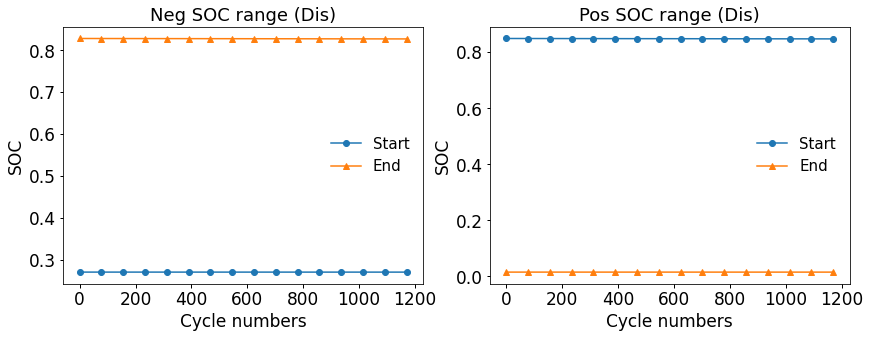

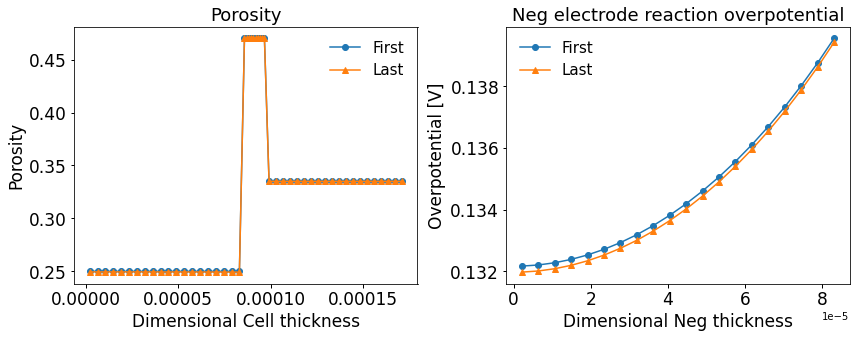

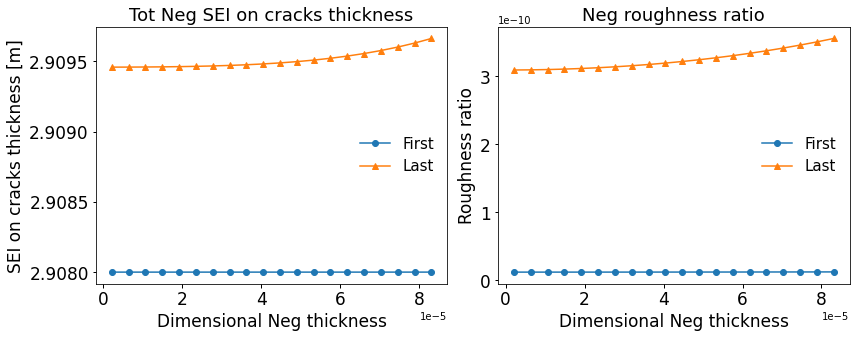

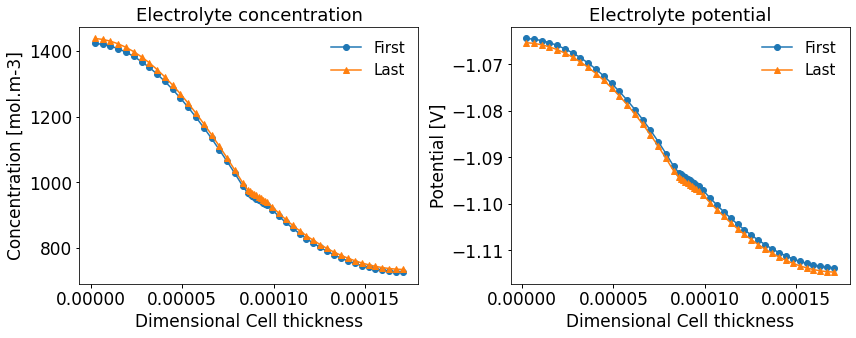

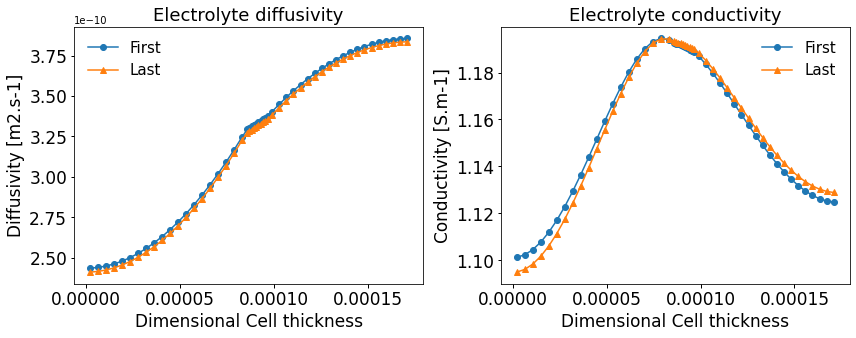

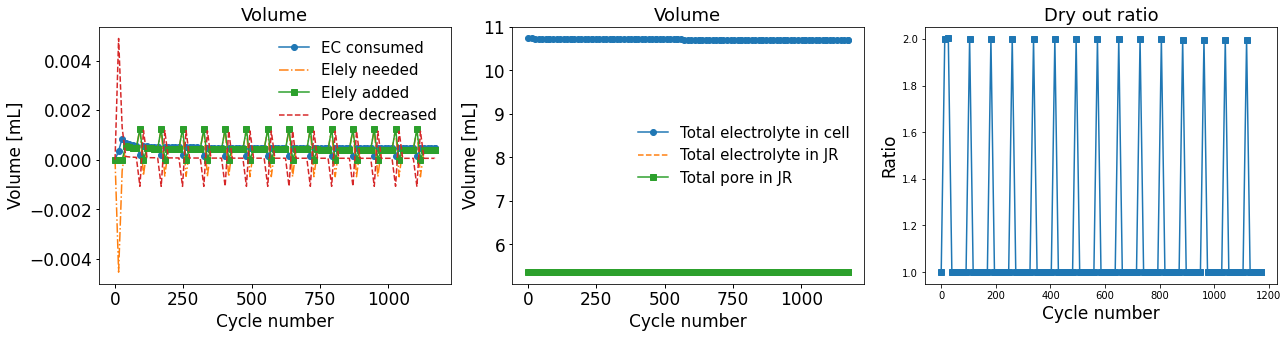

In [7]:
# scan:
index_list = np.arange(1,len(Para_dict_list)+1,1)
for index_list_i, Para_dict_i in zip(index_list,Para_dict_list):
    Run_P2_till_Fail(
        index_list_i, Para_dict_i,   Path_pack,
        keys_all,   exp_text_list, exp_index_pack,Niall_data
    )
""" 
if __name__ == "__main__":
    pool = multiprocessing.Pool(1)
    processes = [pool.apply_async(
        Run_model_wwo_dry_out, 
        args=(
            index_list_i, Para_dict_i,   Path_pack,
            keys_all,   exp_text_list, exp_index_pack,Niall_data
        )
            ) 
            for index_list_i, Para_dict_i in zip(index_list,Para_dict_list)]
    result = [p.get() for p in processes]
 """
 


In [8]:
# Write all seperate excel files into a big file:
for index_list_i in index_list:
    #print(index_list_i)
    old_book = str(index_list_i) + '_' + book_name_xlsx
    #print(old_book)
    #open excel:
    data_old = openpyxl.load_workbook(BasicPath + Target + old_book)   
    data_tar = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx) 

    table_old = data_old.get_sheet_by_name(str(index_list_i))
    nrows_old = table_old.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数


    table_tar = data_tar.get_sheet_by_name(sheet_name_xlsx)
    nrows_tar = table_tar.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数
    list_old = [];
    #print(nrows_old,nrows_tar)
    for i in range(1,nrows_old+1):
        for j in range(1,ncolumns_old+1):
            list_old.append(table_old.cell(row=i,column=j).value)
    
    list_old = [list_old,]
    for i in range(1, len(list_old)+1):
            for j in range(1, len(list_old[i-1])+1):
                #print(i,j,list_old[i-1][j-1]    )
                table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
    data_tar.save(BasicPath + Target + book_name_xlsx) 
    data_tar.close()

